# Customer Call Analytics

In [ ]:
from openai import AzureOpenAI
import os

import chromadb
from textblob import TextBlob
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud
import spacy

import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter


import seaborn as sns
sns.set()
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore

from ragas import evaluate, EvaluationDataset
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)


nlp = en_core_web_md.load()
nltk.download('stopwords')
nltk.download('all')

In [2]:
azure_endpoint = "****************************************"
azure_deployment = "****************************************"
api_key = "****************************************"

client = AzureOpenAI(
  api_key = api_key,  
  api_version = "2024-02-01",
  azure_endpoint = azure_endpoint
)
chroma_client = chromadb.Client()

c:\Users\taiottun\AppData\Local\Programs\Python\Python312\Lib\site-packages\posthog\client.py:345: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().replace(tzinfo=tzutc())


##### Question 1: Use a large language model of your choice to analyse the customer side of the transcript.

In [101]:
query = "Identify the sentiment (positive, negative, neutral) of the call"
query2 = "Determine call outcome (issue resolved, follow-up action needed)"

In [ ]:
def dynamic_document_chunking(file, max_chunk_size=500):
    nlp = spacy.load('en_core_web_sm')
    document = f'transcripts_v3\{file}'
    with open(document, 'r') as f:
        text_list = f.read().split(".")
        member_lines = [line for line in text_list if 'Member:' in line]
        text = ' '.join(member_lines)
        doc = nlp(text)
        chunks = []
        current_chunk = []
        current_size = 0

        for sent in doc.sents:
            if current_size + len(sent.text) > max_chunk_size:
                chunks.append(" ".join(current_chunk))
                current_chunk = [sent.text]
                current_size = len(sent.text)
            else:
                current_chunk.append(sent.text)
                current_size += len(sent.text)
        
        if current_chunk:
            chunks.append(" ".join(current_chunk))
        
        return chunks

In [ ]:
transcripts = []
for path in os.listdir('transcripts_v3'):
    if os.path.isfile(os.path.join('transcripts_v3', path)):
        transcripts.append(path)
documents = []
for transcript in transcripts:
    document = dynamic_document_chunking(transcript)
    documents.append(document)
flattened_documents = [item for sublist in documents for item in sublist]

In [6]:
def create_vector_db(collection, chunks):
    collection.add(
        documents=chunks,
        ids = [f"id_{i}" for i in range(len(chunks))]
    )
    return collection


In [7]:
collection = chroma_client.create_collection(name="Transcripts_Collection")
transcripts_collection = create_vector_db(collection, flattened_documents)

c:\Users\taiottun\AppData\Local\Programs\Python\Python312\Lib\site-packages\posthog\client.py:345: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().replace(tzinfo=tzutc())
c:\Users\taiottun\AppData\Local\Programs\Python\Python312\Lib\site-packages\posthog\request.py:40: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  body["sentAt"] = datetime.utcnow().replace(tzinfo=tzutc()).isoformat()
c:\Users\taiottun\AppData\Local\Programs\Python\Python312\Lib\site-packages\posthog\client.py:345: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: da

In [8]:
def vector_retriever(query, collection):
    vector_results = collection.query(query_texts=[query], n_results=5)
    vector_results_scores = vector_results['documents']
    return vector_results_scores

In [9]:
PROMPT = f"""
ROLE:
You are an exceptional customer service professional. 
You are very competent and able to extract meaningful insights from transcripts of customer calls that are submitted to you.
You are provided with customer side of the transcript only to analyse
INSTRUCTION: Respond to the following question: "{{}}"
CONTEXT: "{{}}"
SUMMARY: (Provide a one or two sentence summary)
"""

In [10]:
def generate_output(PROMPT):
    resp = client.chat.completions.create(
        model="gpt-35-turbo",
        temperature=0,
        messages = [
            {
                "role": "user",
                "content": PROMPT
            }
        ],
    )
    answer = resp.choices[0].message.content
    print(answer)

In [11]:
query1_context = vector_retriever(query, transcripts_collection)
query1_context

c:\Users\taiottun\AppData\Local\Programs\Python\Python312\Lib\site-packages\posthog\client.py:345: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().replace(tzinfo=tzutc())


[["No, that's all \n\nMember: Thank you, bye  Is there anything else you'd like to add or discuss before we end the call?\n\nMember: No, that's all \n\nMember: Thank you, bye",
  "Member: You too, thank you  Is there anything else I can help you with?\n\nMember: No, I think that's all  Have a great day!\n\n Member: You too, thanks \n\nMember: Okay, got it \n\nMember: Will do, thanks \n\n(pause)\n\nPA Agent: Emily, is there anything else I can help you with before we end the call?\n\nMember: No, I think that's all  Have a great day!\n\n Member: You too, thanks",
  "No, that's all \n\nMember: Thank you \n\nCustomer Support: Is there anything else I can assist you with before we end the call?\n\nMember: No, that's all",
  "I appreciate your help  Is there anything else I can assist you with today?\n\nMember: No, that's all \n\nMember: You too \n\n(pause)\n\n Customer Support: Is there anything else I can assist you with before we end the call?\n\nMember: No, that's all  Goodbye!\n\nMember

In [15]:
formatted_prompt1 = PROMPT.format(query1_context, query)
generate_output(formatted_prompt1)

The sentiment of the calls is neutral as the customers do not express any strong emotions and are satisfied with the assistance provided.


In [33]:
query2_context = vector_retriever(query2, transcripts_collection)
query2_context

[["No, that's all \n\nMember: Thank you \n\nCustomer Support: Is there anything else I can assist you with before we end the call?\n\nMember: No, that's all",
  "No, that's all  Is there a preferred phone number we can reach you at for the follow-up call?\n\nMember: Yes, my cell phone number is 555-123-4567 \n\nMember: Thank you, bye!\n\n Customer Support: Bye, Emily",
  "It's Dr  Can you please hold for just a moment while I check on the eligibility and coverage for this procedure?\n\n Member: Sure, thank you \n\nMember: Okay, that's fine \n\nMember: Okay, got it \n\nMember: Great, thank you so much for your help  Is there anything else I can assist you with today?\n\nMember: No, that's all \n\nMember: You too \n\nPA Agent: Emily, can you please confirm that you'd like to receive a callback from our office if there are any issues with your claim?\n\n Member:",
  "This is ridiculous \n\nMember: Yes, please do that \n\n Member: (on hold for 2 minutes)\n\nCustomer Support: I apologize fo

In [14]:
formatted_prompt2 = PROMPT.format(query2_context, query2)
generate_output(formatted_prompt2)

The customer did not require any further assistance in all four transcripts, except for one where they requested a callback if there were any issues with their claim. Therefore, the call outcomes were either issue resolved or no follow-up action needed.


##### AREAS OF IMPROVEMENT
- Hybrid search (semantic search + keyword search)
- Chunking (semantic chunking, fixed-size chunking, topic based chunking, frequency based chunking)
- Query re-writing 

##### Question 2: Use appropriate metrics to monitor the performance of your model.

**Context precision** measures the signal-to-noise ratio of the retrieved context. This metric is computed using the question and the contexts.

**Context recall** measures if all the relevant information required to answer the question was retrieved. This metric is computed based on the ground truth (this is the only metric in the framework that relies on human-annotated ground truth labels) and the contexts.

**Faithfulness** measures the factual accuracy of the generated answer. The number of correct statements from the given contexts is divided by the total number of statements in the generated answer. This metric uses the question, contexts and the answer.

**Answer relevancy** measures how relevant the generated answer is to the question. This metric is computed using the question and the answer. For example, the answer “England is in western Europe.” to the question “Where is England and what is it’s capital?” would achieve a low answer relevancy because it only answers half of the question.

In [141]:


question_answering_template = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. 
Use two sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:
"""

questions = [query, query2]
ground_truths = ["Generally positive", "Some issues were resolved, others requiring follow-up"]
answers = []
contexts = []

In [146]:
for query in questions:
  query_context = vector_retriever(query, transcripts_collection)
  formatted_prompt = PROMPT.format(query_context, query)
  answers.append([generate_output(formatted_prompt)])
  contexts.append([query_context])

data_dict = {}
data = {
        "question": questions,
        "answer": answers,
        "contexts": contexts,
        "ground_truths": ground_truths}
data_list = [
    {
        "user_input": question,
        "response": answer[0],
        "retrieved_contexts": [str(c) for c in context[0]],
        "reference": ground_truth
    }
    for question, answer, context, ground_truth in zip(questions, answers, contexts, ground_truths)
]
evaluation_data = EvaluationDataset.from_list(data_list)

result = evaluate(
    dataset = evaluation_data, 
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
)

df = result.to_pandas()
df

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

c:\Users\taiottun\AppData\Local\Programs\Python\Python312\Lib\site-packages\ragas\metrics\_context_precision.py:147: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
c:\Users\taiottun\AppData\Local\Programs\Python\Python312\Lib\site-packages\ragas\metrics\base.py:281: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
c:\Users\taiottun\AppData\Local\Programs\Python\Python312\Lib\site-packages\ragas\metrics\_context_recall.py:187: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
c:\Users\taiottun\AppData\Local\Programs\Python\Python312\Lib\site-packages\ragas\metrics\base.py:281: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRec

,user_input,retrieved_contexts,response,reference,context_precision,context_recall,faithfulness,answer_relevancy
0,"Determine call outcome (issue resolved, follow...","[[""No, that's all \n\nMember: Thank you \n\nCu...",The customer did not require any further assis...,Generally positive,NaN,NaN,NaN,NaN
1,"Determine call outcome (issue resolved, follow...","[[""No, that's all \n\nMember: Thank you \n\nCu...",The customer did not require any further assis...,"Some issues were resolved, others requiring fo...",NaN,NaN,NaN,NaN


##### Question 3: Use methods of your choice (e.g. exploratory data analysis, statistical methods, visualisations etc.)  to extract useful insights from the data.

In [18]:
def read_transcripts(file_list):
    transcripts = []
    member_lines = []
    for filename in file_list:
        try:
            document = f'transcripts_v3\{filename}'
            with open(document, 'r', encoding='utf-8') as file:
                content = file.read()
                transcripts.append(content)
            member_lines = [line for line in transcripts if 'Member:' in line]
        except FileNotFoundError:
            print(f"Warning: File {document} not found")
        except Exception as e:
            print(f"Error reading {document}: {str(e)}")         
    return member_lines

transcript_files = []
for path in os.listdir('transcripts_v3'):
    if os.path.isfile(os.path.join('transcripts_v3', path)):
        transcript_files.append(path)
transcript_list = read_transcripts(transcript_files)

<string>:6: SyntaxWarning: invalid escape sequence '\{'
<>:6: SyntaxWarning: invalid escape sequence '\{'
<string>:6: SyntaxWarning: invalid escape sequence '\{'
<>:6: SyntaxWarning: invalid escape sequence '\{'
C:\Users\taiottun\AppData\Local\Temp\ipykernel_15928\2617711913.py:6: SyntaxWarning: invalid escape sequence '\{'
  document = f'transcripts_v3\{filename}'


### Sentiment Analysis

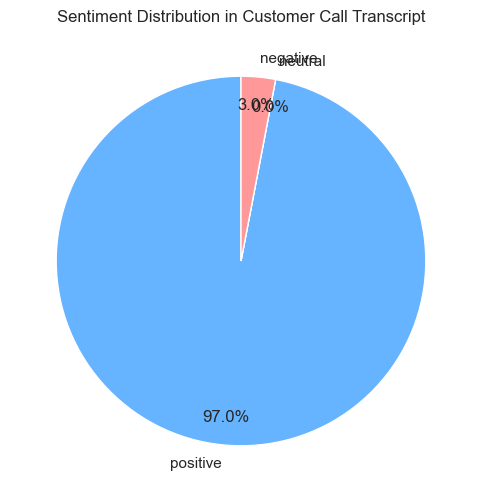

In [147]:
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

sentiment_scores = [(flattened_document, analyze_sentiment(flattened_document)) for flattened_document in transcript_list if flattened_document.strip() != ""]
sentiment_categories = [(line, "positive" if score > 0 else "neutral" if score == 0 else "negative") for line, score in sentiment_scores]
sentiment_counts = {'positive': 0, 'neutral': 0, 'negative': 0}
for _, sentiment in sentiment_categories:
    sentiment_counts[sentiment] += 1

plt.figure(figsize=(6,6))
plt.pie(sentiment_counts.values(), labels=sentiment_counts.keys(), 
        autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99','#ff9999'],
        pctdistance=0.85, labeldistance=1.1)
plt.title("Sentiment Distribution in Customer Call Transcript")
plt.show()

#### Topic Modelling

In [32]:
removal = ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []

for summary in nlp.pipe(transcript_list):
   proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)

dictionary = Dictionary(tokens)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
corpus = [dictionary.doc2bow(doc) for doc in tokens]

lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 10, passes=10)
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

In [148]:
pyLDAvis.save_html(lda_display, 'index.html')

#### Word Cloud

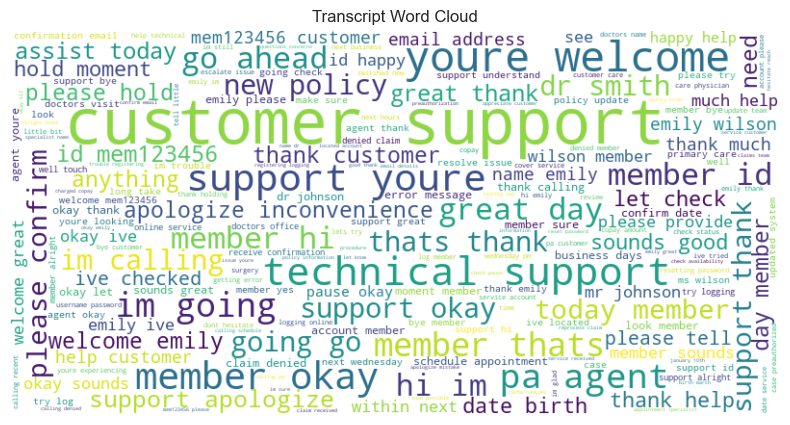

In [149]:
transcript_text = " ".join(transcript_list)
transcript_text = transcript_text.lower()
transcript_text = re.sub(r'[^\w\s]', '', transcript_text)
words = transcript_text.split()
stop_words = set(stopwords.words('english'))
cleaned_words = [word for word in words if word not in stop_words]
cleaned_text = " ".join(cleaned_words)

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(cleaned_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Transcript Word Cloud')
plt.show()


#### Most Common words

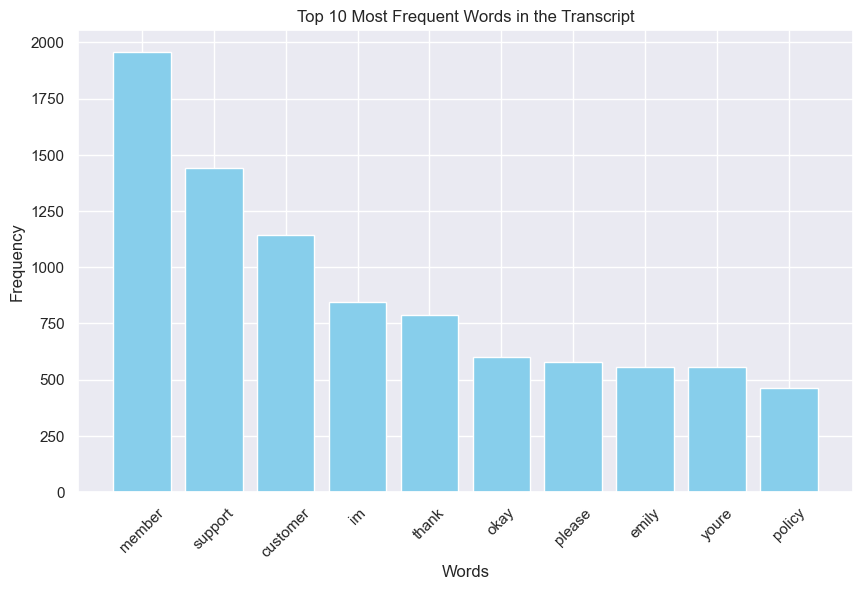

In [150]:
transcript_dialogues = " ".join(transcript_list)
transcript_dialogues = transcript_dialogues.lower()
transcript_dialogues = re.sub(r'[^\w\s]', '', transcript_dialogues)
tokenized_dialogues = nltk.word_tokenize(transcript_dialogues)
cleaned_dialogues = [word for word in tokenized_dialogues if word not in stop_words]


# 10 most common words
word_counts = Counter(cleaned_dialogues)
common_words = word_counts.most_common(10)
words, counts = zip(*common_words)

# Plot a bar chart
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.title('Top 10 Most Frequent Words in the Transcript')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

the most prominent words in the conversation, showing the key topics and focus areas. 

#### Customer Focus Analysis and Intent Detection

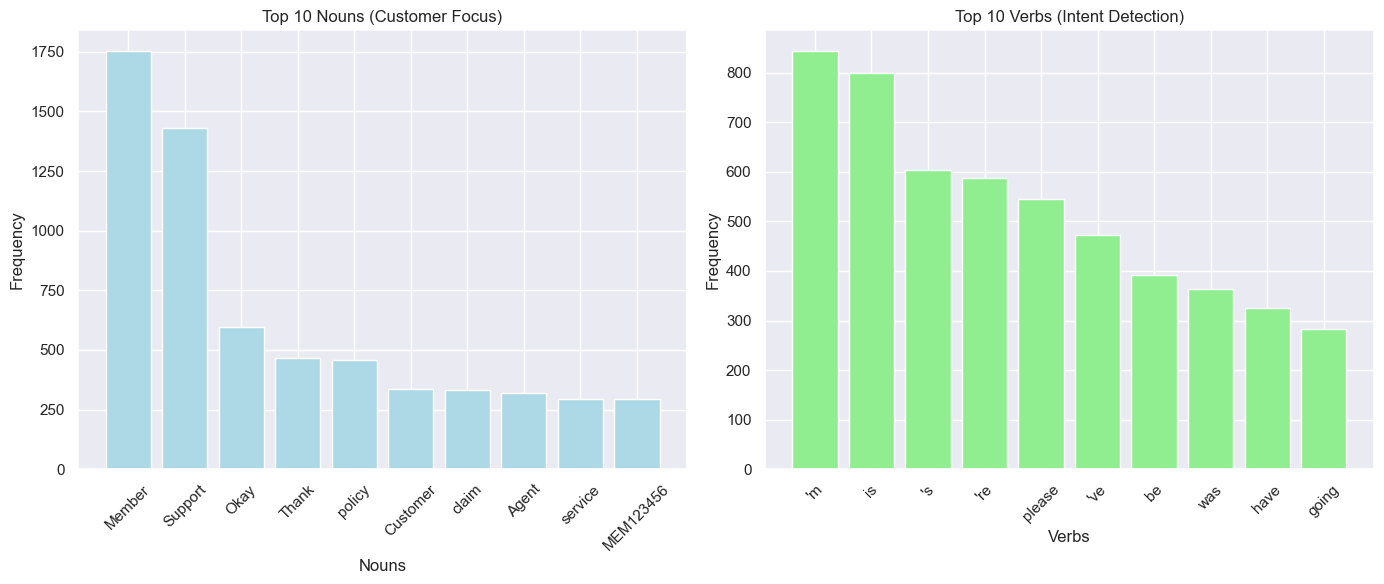

In [151]:
transcript_texts = " ".join(transcript_list)
member_dialogues = "\n".join([line for line in transcript_texts.split("\n") if 'member' in line.lower()])
member_dialogues = member_dialogues.lower()
member_dialogues = re.sub(r'[^\w\s]', '', member_dialogues)
cleaned_member_dialogues = [word for word in member_dialogues if word not in stop_words]
cleaned_member_dialogues = " ".join(transcript_list)
tokenized_words = nltk.word_tokenize(cleaned_member_dialogues)
pos_tags = nltk.pos_tag(tokenized_words)

def extract_pos(pos_tags, pos_filter):
    return [word for word, tag in pos_tags if tag.startswith(pos_filter)]

nouns = extract_pos(pos_tags, 'NN')
verbs = extract_pos(pos_tags, 'VB')

common_nouns = Counter(nouns).most_common(10)
common_verbs = Counter(verbs).most_common(10)
nouns, noun_counts = zip(*common_nouns)
verbs, verb_counts = zip(*common_verbs)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].bar(nouns, noun_counts, color='lightblue')
axes[0].set_title('Top 10 Nouns (Customer Focus)')
axes[0].set_xlabel('Nouns')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(verbs, verb_counts, color='lightgreen')
axes[1].set_title('Top 10 Verbs (Intent Detection)')
axes[1].set_xlabel('Verbs')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


**Customer Focus Analysis**: 
Extracts and counts the most common nouns to understand what topics are frequently discussed.

**Intent Detection**: 
Extracts and counts the most common verbs to detect the actions or requests mentioned in the conversation.


This analysis helps to understand the intent behind the conversation—whether the customer is seeking information, requesting a service, or the agent is offering support or verification. By identifying these actions, customer service teams can anticipate and address specific needs more effectively.